<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Beetle Mortality Data
Author(s): Paul Miles | Date Created: June 18, 2018

This is a binomial logistic regression example with dose-response data.

A. Dobson, "An Introduction to Generalized Linear Models", Chapman & Hall/CRC, 2002.

In [1]:
# import required packages
import numpy as np
import math
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0


# Define mortality data

In [2]:
# Beetle mortality data
dose = np.array([1.6907, 1.7242, 1.7552, 1.7842,
                 1.8113, 1.8369, 1.8610, 1.8839])
number_of_beetles = np.array([59, 60, 62, 56, 63, 59, 62, 60])
number_of_beetles_killed = np.array([6, 13, 18, 28, 52, 53, 61, 60])

x = np.array([dose, number_of_beetles]).T
y = number_of_beetles_killed

# Define model options
The user is given several modeling options.  The user chooses the desired options by defining the appropriate keywork to `beetle_link`.

- `logitmodelfun`: 
$$y(d,\theta) = \frac{1}{1 + \exp(\theta_0 + \theta_1d)}$$
- `loglogmodelfun`:
$$y(d,\theta) = 1 - \exp(-\exp(\theta_0 + \theta_1d))$$
- `probitmodelfun`:
$$y(d,\theta) = \frac{1}{2}\Big[1 + \text{erf}\Big(\frac{\theta_0 + \theta_1d -\mu}{\sigma\sqrt{2}}\Big)\Big], \quad \mu = 0, \quad \sigma^2 = 1$$

In [3]:
def logitmodelfun(d, t):
    return 1/(1+np.exp(t[0]+t[1]*d))
def loglogmodelfun(d, t):
    return 1 - np.exp(-np.exp(t[0] + t[1]*d))
def nordf(x, mu = 0, sigma2 = 1):
    # NORDF the standard normal (Gaussian) cumulative distribution.
    # NORPF(x,mu,sigma2) x quantile, mu mean, sigma2 variance
    # Marko Laine <Marko.Laine@Helsinki.FI>
    # $Revision: 1.5 $  $Date: 2007/12/04 08:57:00 $
    # adapted for Python by Paul Miles, November 8, 2017
    return 0.5 + 0.5*math.erf((x-mu)/math.sqrt(sigma2)/math.sqrt(2))
def probitmodelfun(d, t):
    tmp = np.vectorize(nordf)
    return tmp(t[0] + t[1]*d)

beetle_link_dictionary = dict(
        logit={'theta0': [60, -35], 'modelfun': logitmodelfun, 
                  'label': 'Beetle data with logit link'},
        loglog={'theta0': [-40, 22], 'modelfun': loglogmodelfun, 
                  'label': 'Beetle data with loglog link'},
        probit={'theta0': [-35, 20], 'modelfun': probitmodelfun, 
                  'label': 'Beetle data with loglog link'},
)
# specify model type
beetle_link = 'loglog'        
beetle_model_object = beetle_link_dictionary[beetle_link]

# Setup MCMC Simulation
Note, $\theta_0 = b_0$ and $\theta_1 = b_1$.

In [4]:
# Initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(
    x, y, user_defined_object=beetle_model_object)
# initialize parameter array
theta0 = beetle_model_object['theta0']
mcstat.parameters.add_model_parameter(name='$b_0$',
                                      theta0=theta0[0])
mcstat.parameters.add_model_parameter(name='$b_1$',
                                      theta0=theta0[1])
# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=5.0e3)

The sum-of-squares function is somewhat involved as you must make sure the data component are the appropriate sizes.

In [5]:
# define sum-of-squares model function
def ssfun(theta,data):
    # unpack data
    ss = np.zeros([1])
    y = data.ydata[0]
    ndp = len(y)
    dose = data.xdata[0][:,0].reshape(ndp, 1)
    n = data.xdata[0][:,1].reshape(ndp, 1)
    obj = data.user_defined_object[0]
    model = obj['modelfun']
    # evaluate model
    p = model(dose, theta)
    # calculate loglikelihood
    ss = -2*(y*np.log(p) + (n-y)*np.log(1-p)).sum()
    return ss

# Define model object:
mcstat.model_settings.define_model_settings(sos_function = ssfun)

# Run simulation
We observe several error messages associated with numerical overflow.  This is acceptable in light of those points being rejected during the simulation.

In [6]:
# Run mcmcrun
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
     $b_0$:    -40.00 [     -inf,       inf] N( 0.00e+00,      inf)
     $b_1$:     22.00 [     -inf,       inf] N( 0.00e+00,      inf)


/anaconda3/envs/pymcmcstat_190/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/pymcmcstat_190/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


 [-----------------100%-----------------] 5000 of 5000 complete in 0.9 sec

# Extract results and display chain statistics

In [7]:
# Extract results
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
# display chain stats
mcstat.chainstats(chain, results)



------------------------------
name      :       mean        std     MC_err        tau     geweke
$b_0$     :   -39.9298     3.1084     0.1059     6.8859     0.9892
$b_1$     :    22.2399     1.7278     0.0592     6.9157     0.9890
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 37.82%
Stage 2: 48.14%
Net    : 85.96% -> 4298/5000
---------------
Chain provided:
Net    : 85.96% -> 4298/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


# Plot the chain and pairwise correlation panel

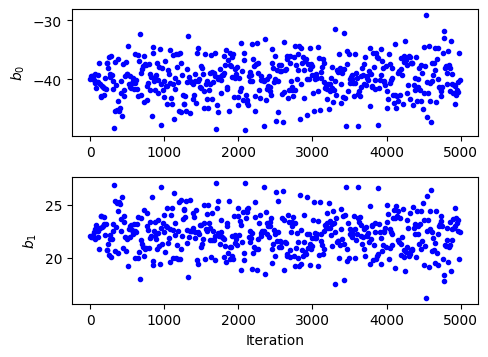

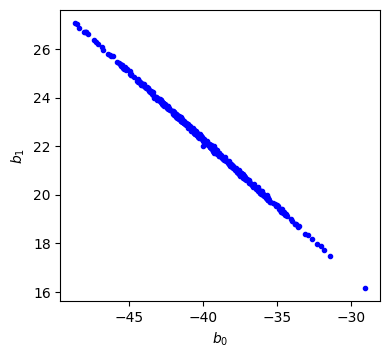

In [8]:
from pymcmcstat import mcmcplot as mcp
# plot chain panel
mcp.plot_chain_panel(chain, names)
# pairwise correlation
settings = dict(fig=dict(figsize=(4, 4)))
f = mcp.plot_pairwise_correlation_panel(chain, names, settings=settings)

# Generate credible intervals
## Option 1

Generating credible/prediction intervals:


Interval generation complete



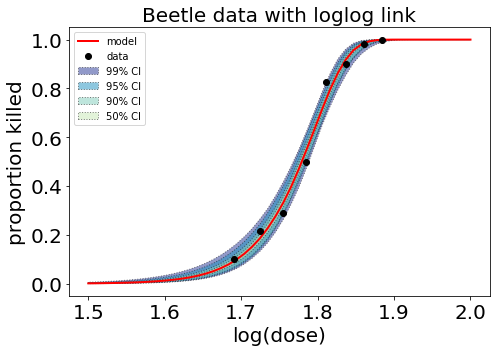

In [9]:
# Define function to generate credible intervals
def predmodelfun(data, theta):
    dose = data.xdata[0][:, 0]
    obj = data.user_defined_object[0]
    model = obj['modelfun']
    # evaluate model
    p = model(dose, theta)
    return p

# define data structure for prediction
predmcmc = MCMC()
xmod = np.linspace(1.5,2)
predmcmc.data.add_data_set(x=xmod,
                           y=xmod,
                           user_defined_object=beetle_model_object)

mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=predmcmc.data,
    modelfunction=predmodelfun);
mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=False);
# plot credible intervals
mcstat.PI.plot_prediction_intervals(adddata=False)

plt.plot(dose, number_of_beetles_killed/number_of_beetles,
         'ok', label = 'data'); # add data points to the plot
plt.xlabel('log(dose)', Fontsize=20)
plt.xticks(Fontsize=20)
plt.ylabel('proportion killed', Fontsize=20)
plt.yticks(Fontsize=20)
plt.title('Beetle data with loglog link', Fontsize=20)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left')
plt.tight_layout()

## Option 2

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

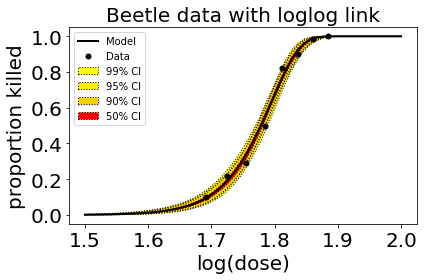

In [25]:
# Define function to generate credible intervals
def predmodelfun2(q, data):
    dose = data.xdata[0][:, 0]
    obj = data.user_defined_object[0]
    model = obj['modelfun']
    # evaluate model
    p = model(dose, q)
    return p

# define data structure for prediction
from pymcmcstat import propagation as up
from pymcmcstat.MCMC import DataStructure

pdata = DataStructure()
xmod = np.linspace(1.5,2)
pdata.add_data_set(x=xmod, y=xmod,
                  user_defined_object=beetle_model_object)

intervals = up.calculate_intervals(chain=chain, results=results, data=pdata,
                                  model=predmodelfun2, nsample=500)
ciset = dict(
    limits=[50, 90, 95, 99],
    )
data_display = dict(
    color='k',
    marker='o')
fig, ax = up.plot_intervals(intervals, xmod,
                            ydata=number_of_beetles_killed/number_of_beetles,
                            xdata=dose,
                            adddata=True,
                            addprediction=False,
                            ciset=ciset,
                            data_display=data_display)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('log(dose)', Fontsize=20)
ax.set_ylabel('proportion killed', Fontsize=20)
ax.set_title('Beetle data with loglog link', Fontsize=20)
fig.tight_layout()